In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras import optimizers, metrics
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

root = '../dataset/hi'
root_soh = '../dataset/soh_charge'
root_model = '../model'


In [18]:

def load_and_process(root, root_soh, dataset, is_cycle = False):
    hiv = pd.read_csv(f'{root}/hiv-charge-CS2_{dataset}.csv')
    soh = pd.read_csv(f'{root_soh}/Csoh-CS2_{dataset}.csv')

    # Mantieni solo le colonne da hiv e soh
    df = pd.merge(hiv, soh, how="right", on="cycle")[["cycle", "hi_v", "SOH"]]
    if is_cycle:
        df[["SOH"]] = (df[["SOH"]] / 1.1) * 100
        df = df.loc[df['SOH'] > 80]
        print(df[["SOH"]] )
        
 
    df_cycle = df[["cycle"]]
    df = df.drop(columns=["cycle"])
    df_hiv = df[["hi_v"]]
    df_soh = df[["SOH"]]
    return df_hiv.values, df_soh.values, df_cycle.values 

# Carica e processa i dataset
df_33_hiv, df_33_soh, df_33_cycle = load_and_process(root, root_soh, 33)
df_35_hiv, df_35_soh, df_35_cycle = load_and_process(root, root_soh, 35)
df_37_hiv, df_37_soh, df_37_cycle = load_and_process(root, root_soh, 37)
df_36_hiv, df_36_soh, df_36_cycle = load_and_process(root, root_soh, 36)
df_38_hiv, df_38_soh, df_38_cycle = load_and_process(root, root_soh, 38)

In [3]:
seq_length = 10
n_features = 1

def split_sequence(data, seq_length, train=False):

    seq = []
    
    for j in data:
        ##to use all values
        # for i in range(len(j) - seq_length - 1):
        #     if train is True:
        #         seq.append(j[i:i+seq_length])
        #     else:
        #         seq.append(j[i + 1:i+seq_length + 1])
        for i in range(len(j) - seq_length):
            if train is True:
                seq.append(j[i:i+seq_length])
            else:
                seq.append(j[i+seq_length-1])
    if train:
        return np.array(seq)
    else:
        return np.array(seq)

In [4]:
# Create sequences for training set

X_train = split_sequence([df_36_hiv, df_38_hiv], seq_length, train=True)
y_train = split_sequence([df_36_soh, df_38_soh], seq_length)

# Calculate mean and std for normalization
mean = X_train.mean()
std = X_train.std()

# Standardize train data
X_train = (X_train - mean) / std

# Shuffle the sequences
# perms = np.random.permutation(len(X_train))
# X_train = X_train[perms]
# y_train = y_train[perms]


print(X_train.shape, y_train.shape)

(1711, 10, 1) (1711, 1)


In [ ]:
#early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50)

# Funzione per creare il modello LSTM
def create_lstm_model(units=128, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(seq_length, n_features)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics=[metrics.RootMeanSquaredError()])
    return model

keras_model = KerasRegressor(build_fn=create_lstm_model, epochs=1000, verbose=1, callbacks=[es])

# Definisci i parametri da testare
param_grid = {
    'units': [128, 256],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam'],
    'batch_size': [64, 128]
}

# Esegui la grid search
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
with open("grid_search_results.txt", "w") as f:
    # Write results in file
    f.write("Best parameters:\n")
    f.write(str(grid_result.best_params_) + "\n")
    f.write("Best score:\n")
    f.write(str(grid_result.best_score_) + "\n")
    f.write("\nAll results:\n")
    for params, mean_score, std_score in zip(grid_result.cv_results_['params'], grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score']):
        f.write(f"{params}: {mean_score} (+/- {std_score})\n")

In [5]:
activation = 'relu' # grid_result.best_params_["activation"] 
batch_size = 128 # grid_result.best_params_["batch_size"]
optimizer = 'adam' # grid_result.best_params_["optimizer"]
units = 128 # grid_result.best_params_["units"] 
epochs = 15000


In [6]:

#define optimizer
adam = optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999)
# define model
model = Sequential()
# to use y_trai as x_train put return_sequences=True
model.add(LSTM(units, activation=activation, input_shape=(seq_length, n_features), return_sequences= False))
model.add(Dense(1))
model.compile(optimizer=adam, loss='mse', metrics=[metrics.RootMeanSquaredError()])

c:\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
# # Create sequences for testing set
X_test = split_sequence([df_35_hiv], seq_length, train = True)
y_test = split_sequence([df_35_soh], seq_length)

# # Normalize the test data using the mean and std from training data
X_test = (X_test - mean) / std

In [8]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=200)

# fit model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data = (X_test, y_test),verbose=1)

Epoch 1/15000
14/14 [==============================] - 2s 45ms/step - loss: 0.6945 - root_mean_squared_error: 0.8334 - val_loss: 0.7015 - val_root_mean_squared_error: 0.8376
Epoch 2/15000
14/14 [==============================] - 0s 21ms/step - loss: 0.6625 - root_mean_squared_error: 0.8139 - val_loss: 0.6713 - val_root_mean_squared_error: 0.8193
Epoch 3/15000
14/14 [==============================] - 0s 20ms/step - loss: 0.6318 - root_mean_squared_error: 0.7949 - val_loss: 0.6415 - val_root_mean_squared_error: 0.8009
Epoch 4/15000
14/14 [==============================] - 0s 20ms/step - loss: 0.6018 - root_mean_squared_error: 0.7757 - val_loss: 0.6117 - val_root_mean_squared_error: 0.7821
Epoch 5/15000
14/14 [==============================] - 0s 20ms/step - loss: 0.5715 - root_mean_squared_error: 0.7560 - val_loss: 0.5804 - val_root_mean_squared_error: 0.7619
Epoch 6/15000
14/14 [==============================] - 0s 20ms/step - loss: 0.5396 - root_mean_squared_error: 0.7346 - val_loss: 0

In [9]:
model.save(f'{root_model}/LSTM.h5') 
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


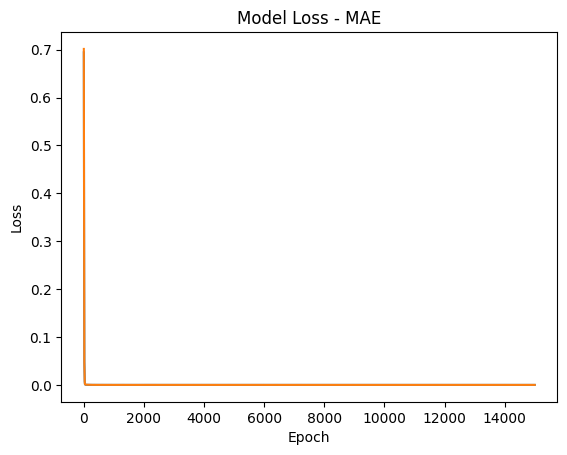

In [10]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.title('Model Loss - MAE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

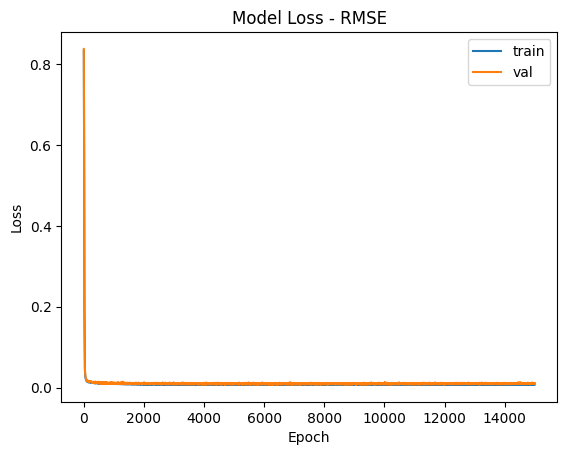

In [11]:
plt.plot(history.history['root_mean_squared_error'], label = 'train')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val')
plt.title('Model Loss - RMSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [22]:
# Change test df to plot different samples
file_number = 33
file_hiv = globals()[f'df_{file_number}_hiv']
file_soh = globals()[f'df_{file_number}_soh']
file_cycle = globals()[f'df_{file_number}_cycle']

X_test = split_sequence([file_hiv], seq_length, train = True)
y_test = split_sequence([file_soh], seq_length)
X_test = (X_test - mean) / std
y_cycle = split_sequence([file_cycle], seq_length)

In [23]:
MSE_train, RMSE_train = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (MSE_train, RMSE_train))
MSE_test, RMSE_test = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (MSE_test,RMSE_test))

Train Score: 0.00 MSE (0.01 RMSE)
Test Score: 0.00 MSE (0.02 RMSE)


24/24 [==============================] - 0s 3ms/step
(748, 1) 1.5257162548836356 1.9388592832056917


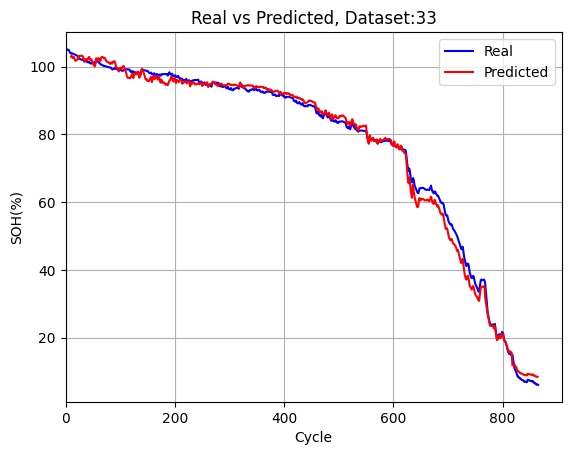

In [24]:
# Predici i valori sul dataset di test
y_pred = model.predict(X_test)
# print(y_pred)
mae = np.abs(y_pred - y_test ).mean()
rmse = np.sqrt(np.power((y_pred - y_test),2).mean())
print(y_pred.shape, mae*100, rmse*100)
# plt.plot((y_test/1.1)*100, label='Real', color='blue')
plt.plot(file_cycle, (file_soh/1.1)*100, label='Real', color='blue')
plt.plot(y_cycle, (y_pred/1.1)*100, label='Predicted', color='red')
# plt.plot((y_pred/1.1)*100, label='Predicted', color='red')
plt.title(f'Real vs Predicted, Dataset:{file_number}')
plt.xlabel('Cycle')
plt.ylabel('SOH(%)')
plt.xlim(left=0)
plt.grid(True)
plt.legend()
plt.show()

In [25]:
df_33_hiv_80, df_33_soh_80, df_33_cycle_80 = load_and_process(root, root_soh, 33, is_cycle=True)
df_35_hiv_80, df_35_soh_80, df_35_cycle_80 = load_and_process(root, root_soh, 35, is_cycle=True)
df_37_hiv_80, df_37_soh_80, df_37_cycle_80 = load_and_process(root, root_soh, 37, is_cycle=True)

            SOH
0    105.186299
1    105.106136
2    104.985427
3    104.855981
4    104.951829
..          ...
498   81.008800
499   80.991008
500   80.962221
501   80.900804
502   80.426742

[503 rows x 1 columns]
            SOH
0    105.164212
1    102.988002
2    102.947537
3    102.928227
4    102.510245
..          ...
552   80.030444
553   80.042219
554   80.020584
557   80.708432
558   80.114637

[539 rows x 1 columns]
            SOH
0    104.708940
1    102.591684
2    102.534571
3    102.515650
4    102.275327
..          ...
535   81.886762
536   81.569328
541   80.779996
542   80.471467
547   80.462461

[540 rows x 1 columns]


In [29]:
file_number = 33
file_hiv = globals()[f'df_{file_number}_hiv_80']
file_soh = globals()[f'df_{file_number}_soh_80']
file_cycle = globals()[f'df_{file_number}_cycle_80']

X_test = split_sequence([file_hiv], seq_length, train = True)
y_test = split_sequence([file_soh], seq_length)
X_test = (X_test - mean) / std
y_cycle = split_sequence([file_cycle], seq_length)

16/16 [==============================] - 0s 3ms/step
(493, 1) 1.1649473928286886 1.344094400636319


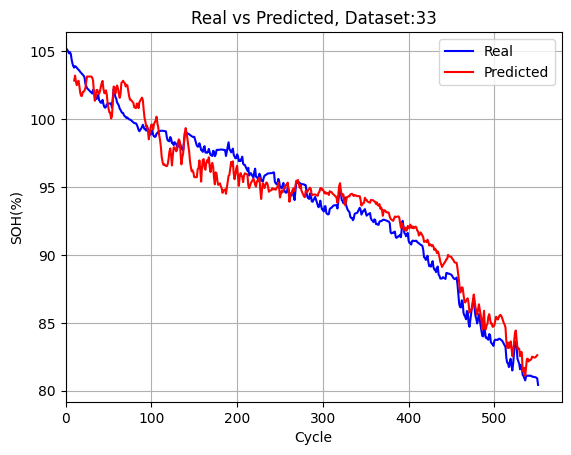

In [30]:
# Predici i valori sul dataset di test
y_pred = model.predict(X_test)
# print(y_pred)
mae = np.abs(y_pred - (y_test *1.1)/100).mean()
rmse = np.sqrt(np.power((y_pred - (y_test *1.1)/100),2).mean())
print(y_pred.shape, mae*100, rmse*100)
# plt.plot((y_test/1.1)*100, label='Real', color='blue')
plt.plot(file_cycle, (file_soh), label='Real', color='blue')
plt.plot(y_cycle, (y_pred/1.1)*100, label='Predicted', color='red')
# plt.plot((y_pred/1.1)*100, label='Predicted', color='red')
plt.title(f'Real vs Predicted, Dataset:{file_number}')
plt.xlabel('Cycle')
plt.ylabel('SOH(%)')
plt.xlim(left=0)
plt.grid(True)
plt.legend()
plt.show()